In [148]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [149]:
df = pd.read_csv('/content/cafethai_prices.csv', parse_dates=['date'], date_format='%d/%m/%Y')
display(df.head())

date      time cash_type          coffee_name  money
0 2023-03-01  08:04:19      card                Latte     75
1 2023-03-01  08:08:54      cash  Americano with Milk     70
2 2023-03-01  08:09:03      card           Cappuccino     75
3 2023-03-01  08:10:26      cash           Cappuccino     75
4 2023-03-01  08:15:37      cash           Cappuccino     75

In [150]:
df.set_index('date', inplace=True)

df.head()

time cash_type          coffee_name  money
date                                                      
2023-03-01  08:04:19      card                Latte     75
2023-03-01  08:08:54      cash  Americano with Milk     70
2023-03-01  08:09:03      card           Cappuccino     75
2023-03-01  08:10:26      cash           Cappuccino     75
2023-03-01  08:15:37      cash           Cappuccino     75

In [151]:
#รวมข้อมูลยอดขายแต่ละเมนู ในแต่ละวัน
daily_sales = df.groupby(['date', 'coffee_name'])['money'].sum().reset_index()
daily_sales.head()

date          coffee_name  money
0 2023-03-01            Americano   1235
1 2023-03-01  Americano with Milk   1890
2 2023-03-01           Cappuccino   1800
3 2023-03-01                Cocoa    350
4 2023-03-01              Cortado    980

In [152]:
# DataFrame for the count of each coffee item sold per day
daily_item_counts = df.groupby(['date', 'coffee_name']).size().reset_index(name='count')
daily_item_counts.head()

date          coffee_name  count
0 2023-03-01            Americano     19
1 2023-03-01  Americano with Milk     27
2 2023-03-01           Cappuccino     24
3 2023-03-01                Cocoa      7
4 2023-03-01              Cortado     14

In [153]:
# DataFrame for the total sales per day for all coffee items
daily_total_sales = df.groupby('date')['money'].sum().reset_index(name='total_sales')
daily_total_sales.head()

date  total_sales
0 2023-03-01         8645
1 2023-03-02         8560
2 2023-03-03         8690
3 2023-03-04         4365
4 2023-03-05         4565

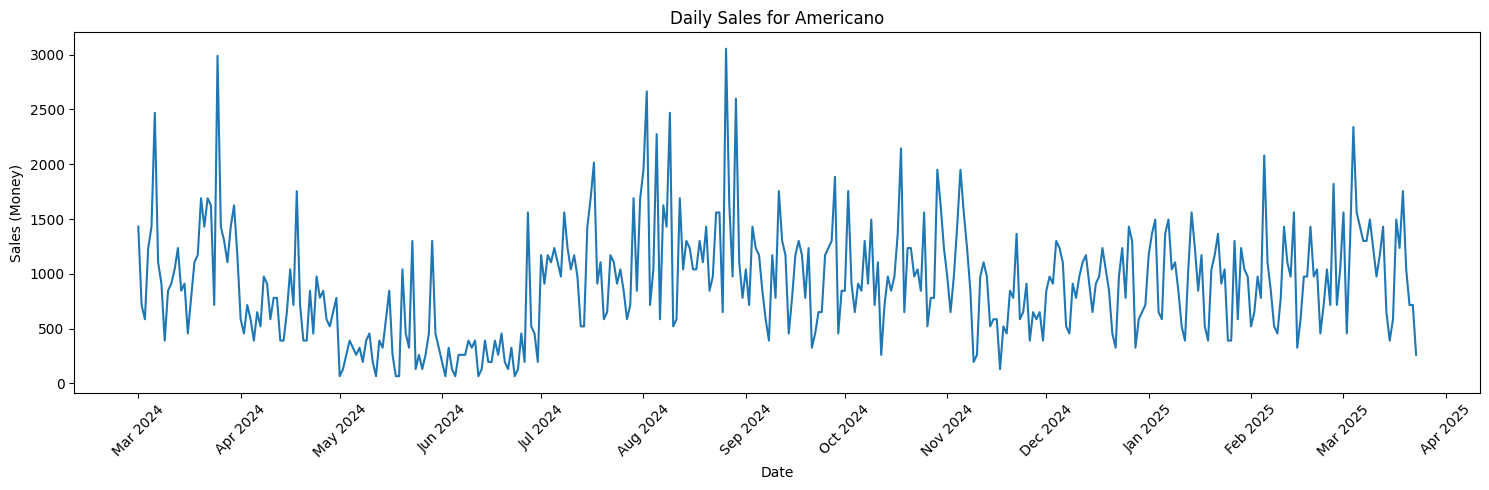

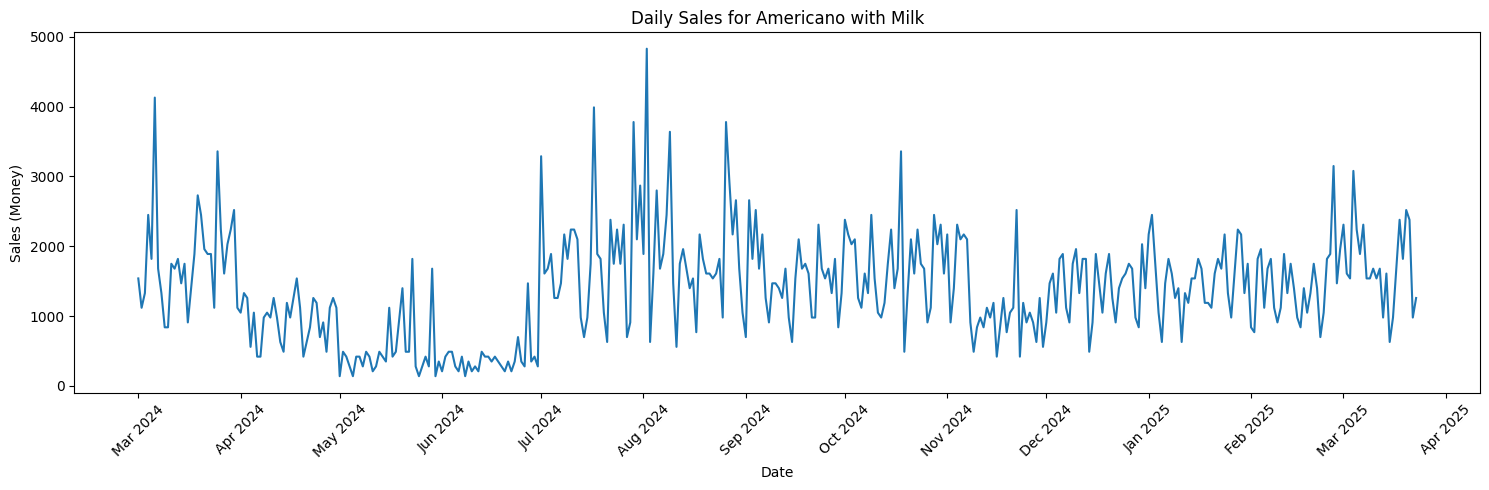

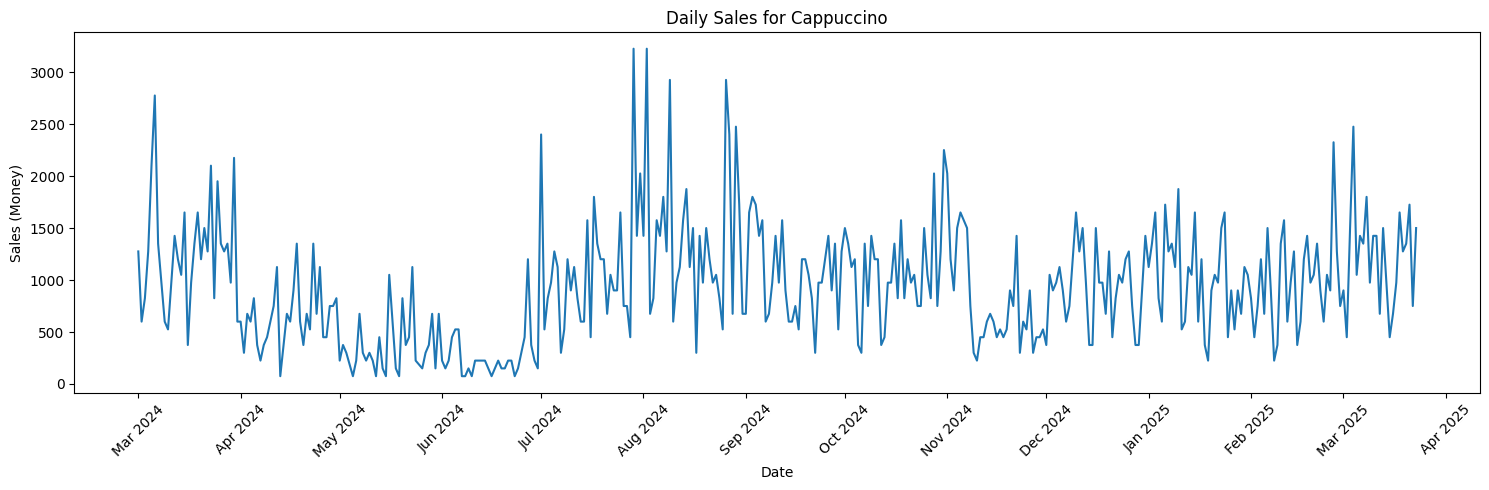

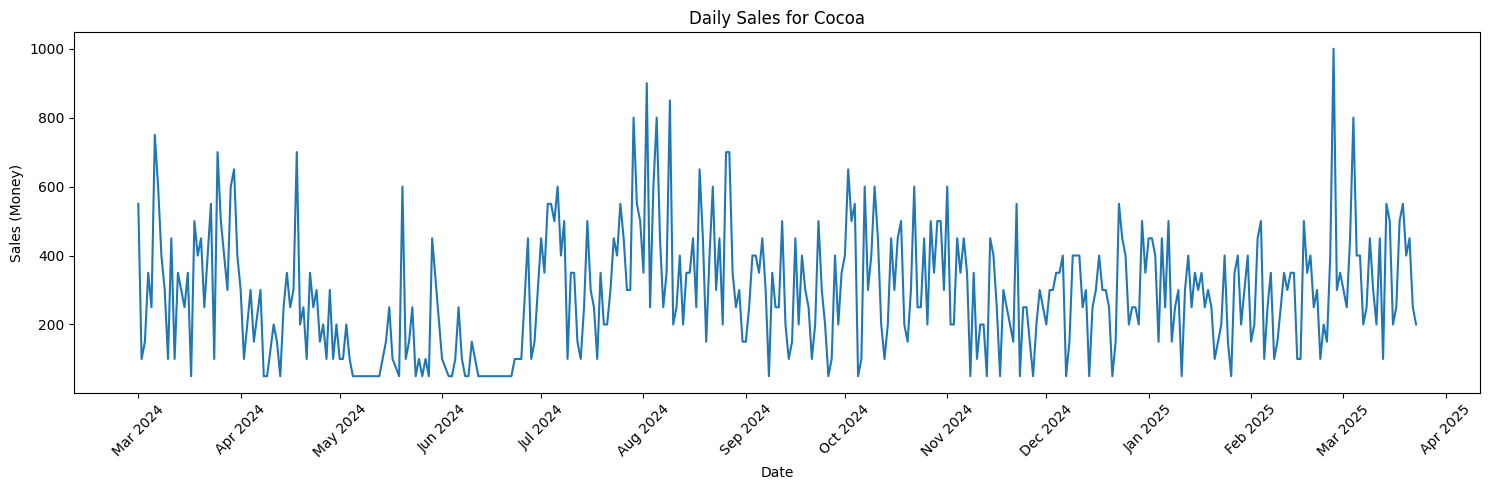

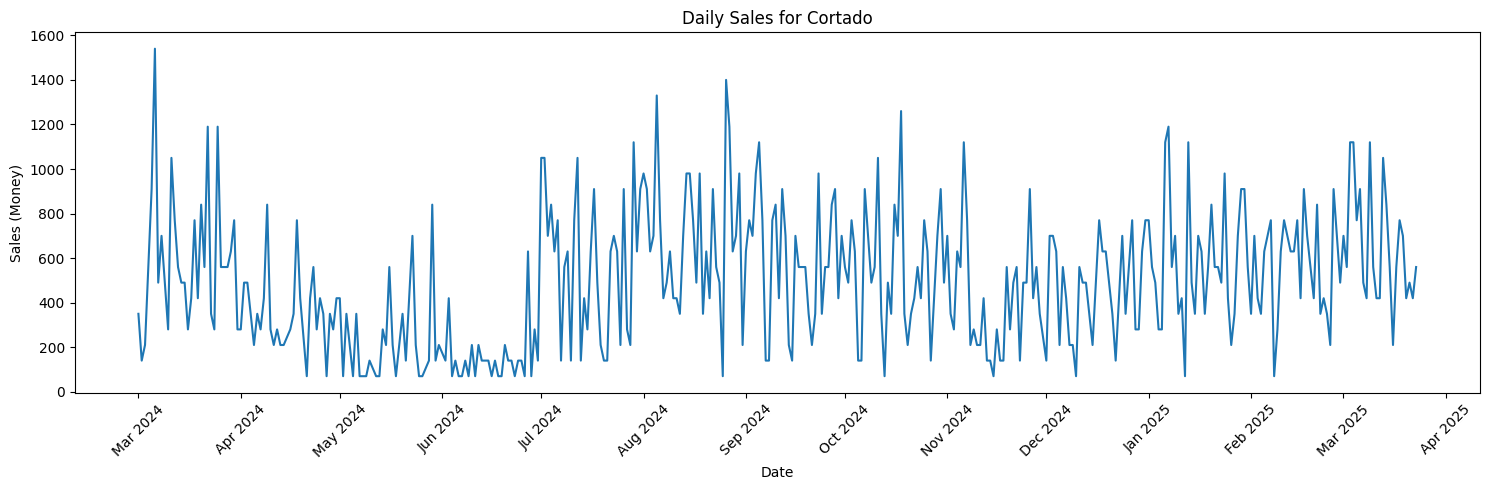

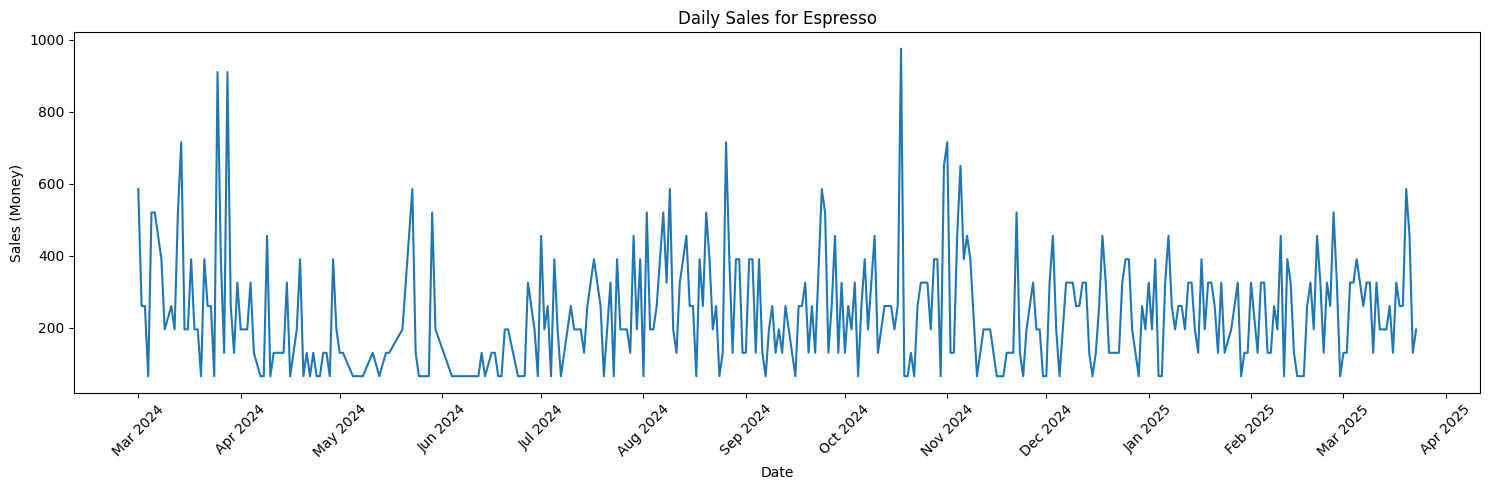

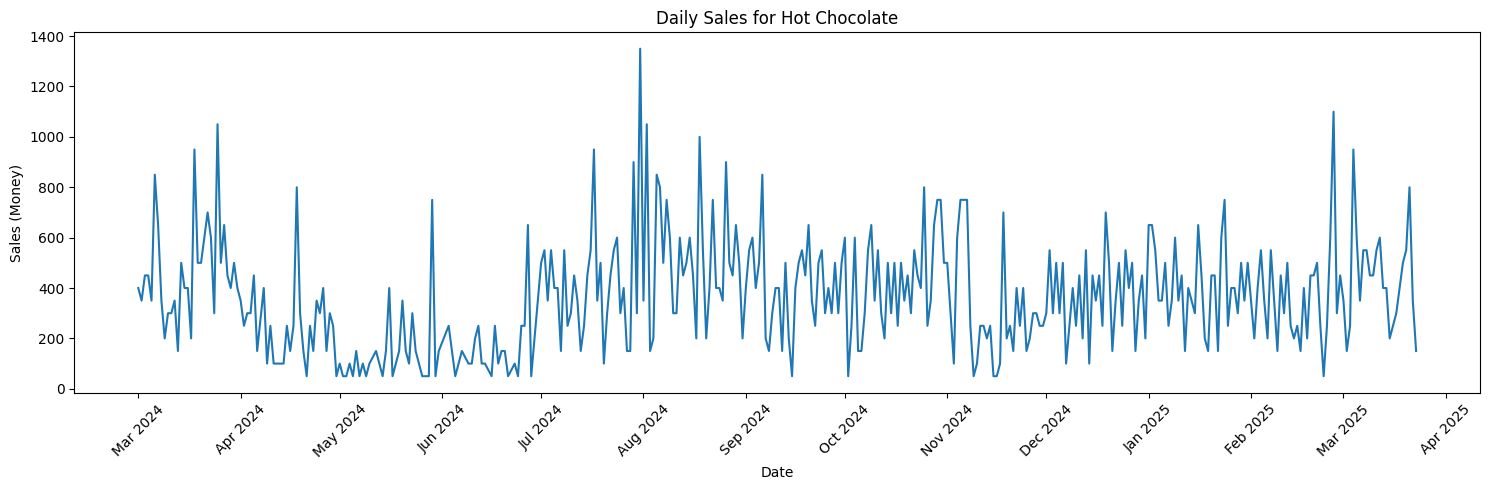

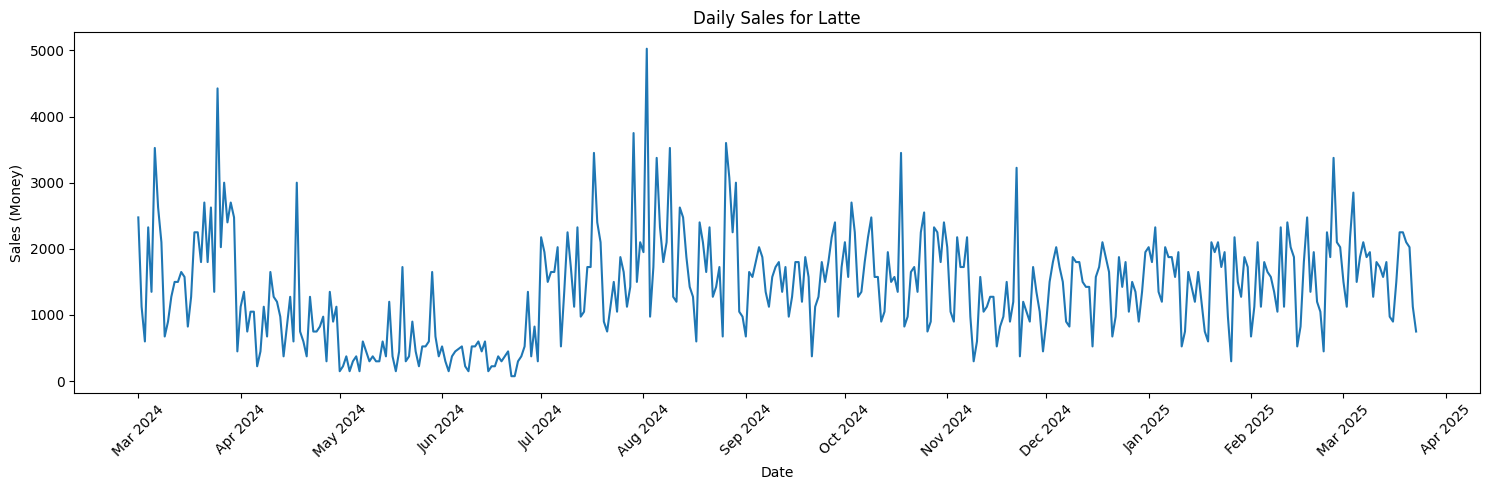

In [154]:
# Plot daily sales for each coffee item
for coffee_name in daily_sales['coffee_name'].unique():
    coffee_sales = daily_sales[daily_sales['coffee_name'] == coffee_name].copy() # Create a copy to avoid SettingWithCopyWarning
    # Ensure date is datetime, convert if needed with the correct format
    if not pd.api.types.is_datetime64_any_dtype(coffee_sales['date']):
         coffee_sales['date'] = pd.to_datetime(coffee_sales['date'], format='%d/%m/%Y', errors='coerce')

    coffee_sales.dropna(subset=['date'], inplace=True) # Remove rows with invalid dates

    # Filter data by date range
    # Update start and end dates if needed based on the correct format
    start_date = '2024-03-01' # Assuming the user wants to start from March 1, 2024
    end_date = '2025-03-23'
    coffee_sales = coffee_sales[(coffee_sales['date'] >= start_date) & (coffee_sales['date'] <= end_date)]

    coffee_sales.set_index('date', inplace=True) # Set date as index for easier plotting


    plt.figure(figsize=(15, 5))
    plt.plot(coffee_sales.index, coffee_sales['money'])
    plt.title(f'Daily Sales for {coffee_name}')
    plt.xlabel('Date')
    plt.ylabel('Sales (Money)')

    # Format x-axis to show month and year
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%b %Y'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())


    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [155]:
def create_sales_features(df):
    # Ensure date is datetime and set as index
    # Check if date is already datetime, if not convert with the correct format
    if not pd.api.types.is_datetime64_any_dtype(df['date']):
        df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y', errors='coerce')

    df.set_index('date', inplace=True)

    # Create features from date
    df['dayofweek'] = df.index.dayofweek # 0 = Monday, 6 = Sunday
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear'] = df.index.dayofyear
    df['year'] = df.index.year # Add year feature

    # Sort by date before creating lag features
    df.sort_index(inplace=True)

    # Create Lag Features (previous sales)
    # We'll use data from 7 days and 14 days ago to help predict
    df['lag_7'] = df['total_sales'].shift(7)
    df['lag_14'] = df['total_sales'].shift(14)

    # Create Rolling Mean
    df['rolling_mean_7'] = df['total_sales'].shift(1).rolling(window=7).mean()

    # Reset index to make date a column again
    df.reset_index(inplace=True)

    return df


daily_total_sales_features = create_sales_features(daily_total_sales.copy())


# Drop rows with NaN values created by lag features
daily_total_sales_features.dropna(inplace=True)

display(daily_total_sales_features.head())

date  total_sales  dayofweek  quarter  month  dayofyear  year  \
14 2023-03-15         7200          2        1      3         74  2023   
15 2023-03-16         7315          3        1      3         75  2023   
16 2023-03-17         7510          4        1      3         76  2023   
17 2023-03-18         5250          5        1      3         77  2023   
18 2023-03-19         4765          6        1      3         78  2023   

     lag_7  lag_14  rolling_mean_7  
14  7290.0  8645.0     6460.000000  
15  7140.0  8560.0     6447.142857  
16  7120.0  8690.0     6472.142857  
17  5735.0  4365.0     6527.857143  
18  3635.0  4565.0     6458.571429

In [156]:
# Convert 'date' column to datetime objects
# Ensure 'date' is a column first if it was set as index
if df.index.name == 'date':
    df.reset_index(inplace=True)

df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y', errors='coerce')

# Display the data types to confirm the conversion
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68359 entries, 0 to 68358
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         68359 non-null  datetime64[ns]
 1   time         68359 non-null  object        
 2   cash_type    68359 non-null  object        
 3   coffee_name  68359 non-null  object        
 4   money        68359 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 2.6+ MB


None

In [157]:
FEATURES = ['dayofweek', 'quarter', 'month', 'dayofyear', 'lag_7', 'lag_14', 'rolling_mean_7']
TARGET = 'total_sales'

In [158]:
X = daily_total_sales_features[FEATURES]
y = daily_total_sales_features[TARGET]

In [159]:
# Determine the split date
split_date = '2025-03-01'

# Ensure the 'date' column is in datetime format for comparison
daily_total_sales_features['date'] = pd.to_datetime(daily_total_sales_features['date'])

# Split data into training and testing sets based on date
train_data = daily_total_sales_features[daily_total_sales_features['date'] < split_date]
test_data = daily_total_sales_features[daily_total_sales_features['date'] >= split_date]

X_train = train_data[FEATURES]
y_train = train_data[TARGET]
X_test = test_data[FEATURES]
y_test = test_data[TARGET]


print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (717, 7)
Shape of y_train: (717,)
Shape of X_test: (61, 7)
Shape of y_test: (61,)


In [160]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [161]:
# XGBoost
xgb_model = xgb.XGBRegressor(n_estimators=100,
                             learning_rate=0.05, # ค่อยๆ เรียนรู้ช้าๆ
                             early_stopping_rounds=10, # ถ้าผลไม่ดีขึ้น 10 รอบให้หยุด
                             random_state=42)

In [162]:
# XGBoost ต้องมี evaluation set เพื่อใช้ early stopping
xgb_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [163]:
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

In [164]:
rf_mae = mean_absolute_error(y_test, rf_pred)
xgb_mae = mean_absolute_error(y_test, xgb_pred)

In [165]:
print(f"\nความคลาดเคลื่อนเฉลี่ยของ Random Forest: {rf_mae:.2f} จากทั้งหมด {len(y_test)} จุดข้อมูล")
print(f"ความคลาดเคลื่อนเฉลี่ยของ XGBoost: {xgb_mae:.2f} จากทั้งหมด {len(y_test)} จุดข้อมูล")
print(f"ยอดขายรวมใน Test Set: {y_test.sum():.2f} บาท")


ความคลาดเคลื่อนเฉลี่ยของ Random Forest: 1128.13 จากทั้งหมด 61 จุดข้อมูล
ความคลาดเคลื่อนเฉลี่ยของ XGBoost: 1035.21 จากทั้งหมด 61 จุดข้อมูล
ยอดขายรวมใน Test Set: 366330.00 บาท


In [166]:
results = pd.DataFrame({
    'Actual': y_test,
    'Random Forest': rf_pred,
    'XGBoost': xgb_pred
})

# Set the index of the results DataFrame to the dates from the test set
results.index = test_data['date']

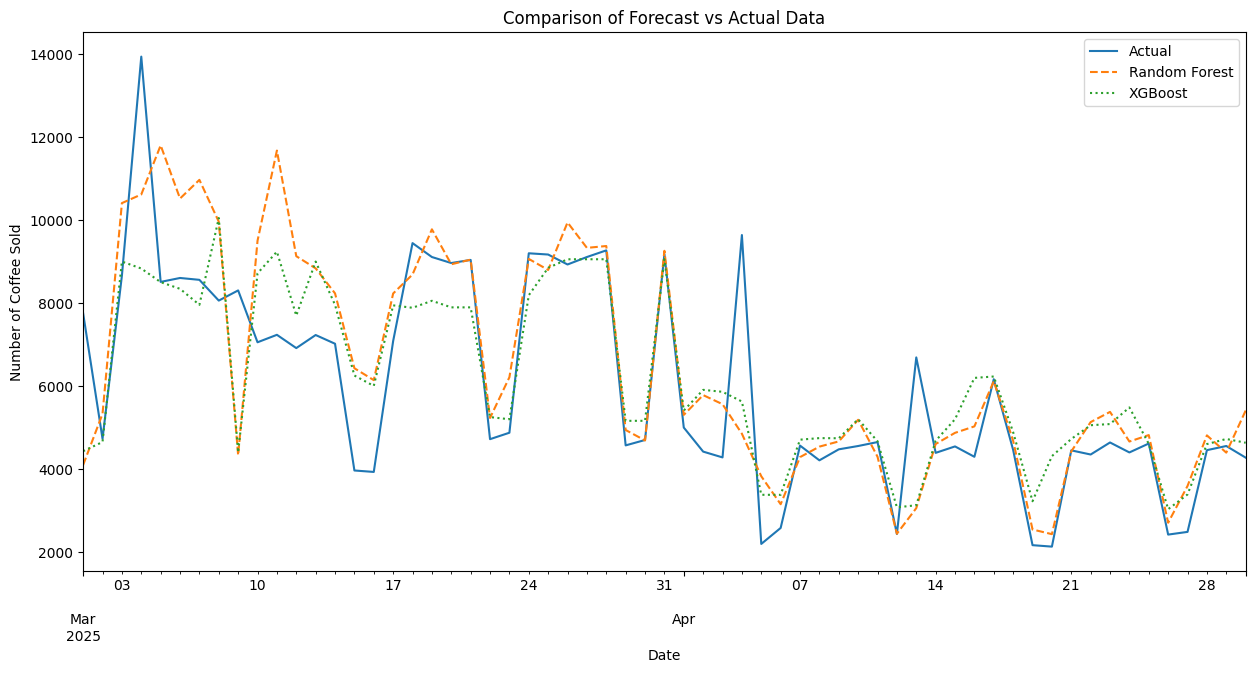

In [167]:
results.plot(figsize=(15, 7), style=['-', '--', ':'],
             title='Comparison of Forecast vs Actual Data')
plt.ylabel('Number of Coffee Sold')
plt.xlabel('Date')
plt.legend()
plt.show()

In [168]:
def plot_feature_importance(model, features, model_name):
    # สร้าง DataFrame ของ feature importance
    fi = pd.DataFrame(data=model.feature_importances_,
                      index=features,
                      columns=['importance'])
    fi_sorted = fi.sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=fi_sorted.index, y=fi_sorted['importance'])
    plt.title(f'Feature Importance of the {model_name} Model') # Changed title to English
    plt.xticks(rotation=45)
    plt.xlabel('Features') # Added x-axis label
    plt.show()

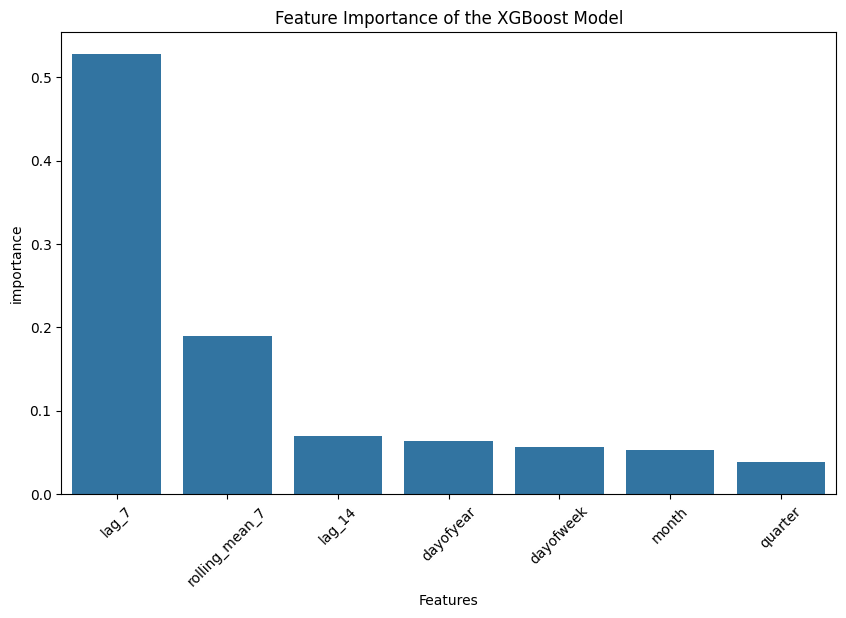

In [169]:
plot_feature_importance(xgb_model, FEATURES, 'XGBoost')

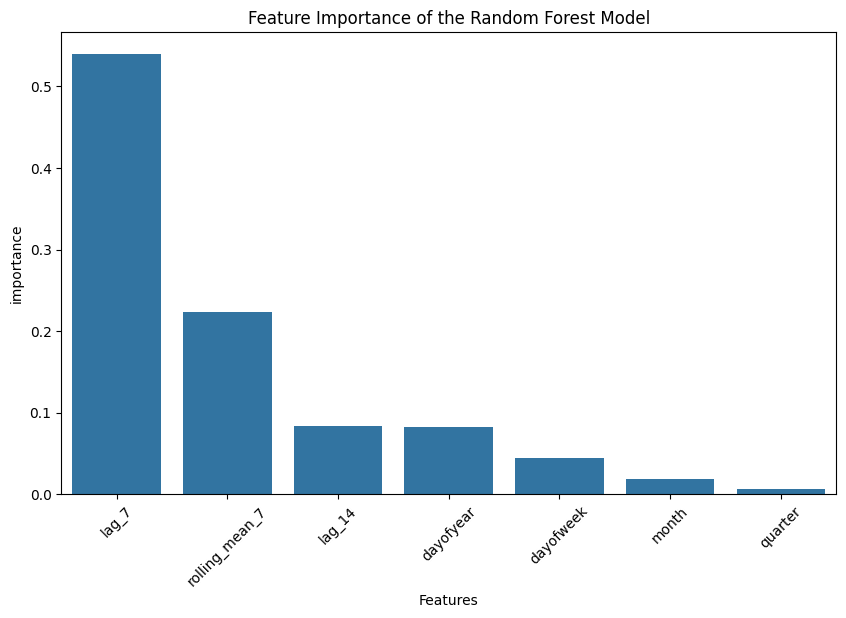

In [170]:
plot_feature_importance(rf_model, FEATURES, 'Random Forest')

In [171]:
#ใช้  prophet

In [172]:
!pip install prophet

In [173]:
from prophet import Prophet

In [174]:
# Prepare data for Prophet: requires 'ds' (datetime) and 'y' (target) columns
# Use the already split train_data and test_data DataFrames

# Add print statements to check columns
print("Columns in train_data:", train_data.columns)
print("Columns in test_data:", test_data.columns)

Columns in train_data: Index(['date', 'total_sales', 'dayofweek', 'quarter', 'month', 'dayofyear',
       'year', 'lag_7', 'lag_14', 'rolling_mean_7'],
      dtype='object')
Columns in test_data: Index(['date', 'total_sales', 'dayofweek', 'quarter', 'month', 'dayofyear',
       'year', 'lag_7', 'lag_14', 'rolling_mean_7'],
      dtype='object')


In [175]:
prophet_train = train_data[['date', 'total_sales']].rename(columns={'date': 'ds', 'total_sales': 'y'})
prophet_test = test_data[['date', 'total_sales']].rename(columns={'date': 'ds', 'total_sales': 'y'})

# Prophet requires a continuous time series without missing dates.
# It's generally recommended to ensure the data has a daily frequency and fill missing dates if necessary.
# For simplicity now, we'll use the data as is, but note this for potential issues.
# If there are missing dates, Prophet can handle them to some extent but performance might be affected.

In [176]:
# Initialize and fit the Prophet model
model = Prophet(weekly_seasonality=True,yearly_seasonality=True)
model.fit(prophet_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5ixv8sdk/8zwxdmin.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5ixv8sdk/vp8ghqd1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68975', 'data', 'file=/tmp/tmp5ixv8sdk/8zwxdmin.json', 'init=/tmp/tmp5ixv8sdk/vp8ghqd1.json', 'output', 'file=/tmp/tmp5ixv8sdk/prophet_modelnawfmhya/prophet_model-20250920094742.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:47:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:47:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [177]:
# Display the index (dates) of the RF/XGBoost test set
display(y_test.index)

Index([731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744,
       745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758,
       759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772,
       773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786,
       787, 788, 789, 790, 791],
      dtype='int64')

In [178]:
# Create a future dataframe for predictions
# We need to predict for the dates in the test set
future = model.make_future_dataframe(periods=len(prophet_test))

In [179]:
# Make predictions
forecast = model.predict(future)

In [180]:
# Display the forecast
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

ds         yhat   yhat_lower    yhat_upper
0 2023-03-15  9233.730622  7011.265559  11787.614101
1 2023-03-16  9251.532056  6824.327884  11557.245678
2 2023-03-17  8906.581304  6730.134576  11076.215240
3 2023-03-18  5968.444038  3596.372182   8385.548817
4 2023-03-19  6036.730926  3762.706288   8206.312499

In [181]:
# Evaluate the Prophet model
# Merge actual values with forecast
prophet_results = forecast.set_index('ds')[['yhat']].join(prophet_test.set_index('ds')[['y']])
prophet_results.dropna(inplace=True) # Drop rows where there are no actual values (if future was longer than test)

In [182]:
# Calculate MAE
prophet_mae = mean_absolute_error(prophet_results['y'], prophet_results['yhat'])

print(f"ความคลาดเคลื่อนเฉลี่ยของ Prophet: {prophet_mae:.2f} จากทั้งหมด {len(prophet_results)} จุดข้อมูล")
print(f"ยอดขายรวมใน Test Set (สำหรับ Prophet): {prophet_results['y'].sum():.2f} บาท")

ความคลาดเคลื่อนเฉลี่ยของ Prophet: 1180.71 จากทั้งหมด 61 จุดข้อมูล
ยอดขายรวมใน Test Set (สำหรับ Prophet): 366330.00 บาท


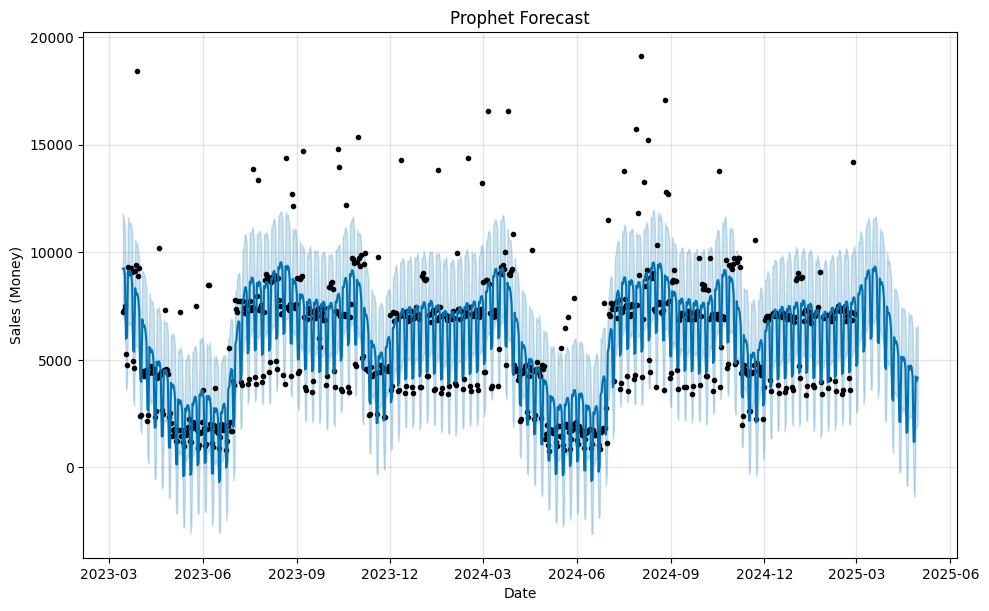

In [183]:
# Plot the forecast
fig1 = model.plot(forecast)
plt.title('Prophet Forecast')
plt.xlabel('Date')
plt.ylabel('Sales (Money)')
plt.show()

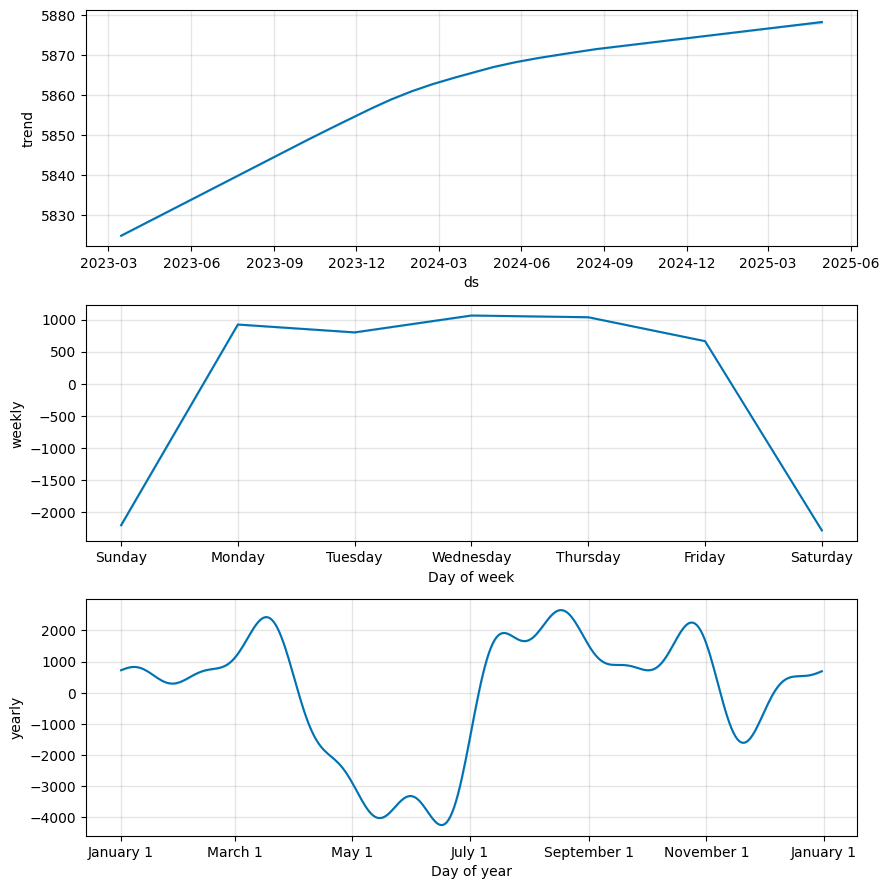

In [184]:
# Plot the components of the forecast
fig2 = model.plot_components(forecast)
plt.show()

In [185]:
pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-_l5ns7b7
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-_l5ns7b7
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit fcd09fe8b6bf57643bde7847bf42a6719b7ee205
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [186]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

In [187]:
pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-small",
  device_map="cuda",
  dtype=torch.bfloat16,
)

In [188]:
# Prepare the data for Chronos
# Chronos expects a torch tensor as input. We'll use the 'total_sales' column
# Filter data before the split date
split_date = pd.to_datetime('2025-03-01')
historical_sales_before_split = daily_total_sales[daily_total_sales['date'] < split_date].copy()


# Convert the 'total_sales' column from the filtered data to a torch tensor
context = torch.tensor(historical_sales_before_split['total_sales'].values)

# Define the prediction length (e.g., 60 days for one month forecast)
prediction_length = 60

# Make a forecast using the Chronos pipeline
forecast = pipeline.predict(context, prediction_length)

# The forecast is a distribution. We can get the median prediction.
# The forecast tensor will have shape (num_samples, prediction_length)
# We take the median along the sample dimension (dim=0)
median_prediction = forecast[0].median(dim=0).values

# Display the median prediction
print(f"Chronos Median Forecast for the next {prediction_length} days:")
display(median_prediction)

Chronos Median Forecast for the next 60 days:


tensor([3589.3960, 3722.3364, 7001.5371, 7045.8506, 7045.8506, 7134.4785,
        6957.2236, 3545.0825, 3766.6499, 7045.8506, 6868.5967, 6912.9102,
        7045.8506, 7001.5371, 3545.0825, 3633.7095, 6957.2236, 7045.8506,
        7045.8506, 7001.5371, 7001.5371, 3545.0825, 3589.3960, 7045.8506,
        7001.5371, 6957.2236, 6957.2236, 6868.5967, 3500.7686, 3678.0229,
        6868.5967, 6957.2236, 6868.5967, 7045.8506, 6824.2832, 3500.7686,
        3500.7686, 6957.2236, 6912.9102, 6868.5967, 6868.5967, 6912.9102,
        3500.7686, 3633.7095, 6779.9697, 6824.2832, 6912.9102, 6912.9102,
        6647.0293, 3500.7686, 3589.3960, 6868.5967, 6824.2832, 6957.2236,
        6824.2832, 6779.9697, 3412.1416, 3633.7095, 6824.2832, 6868.5967])

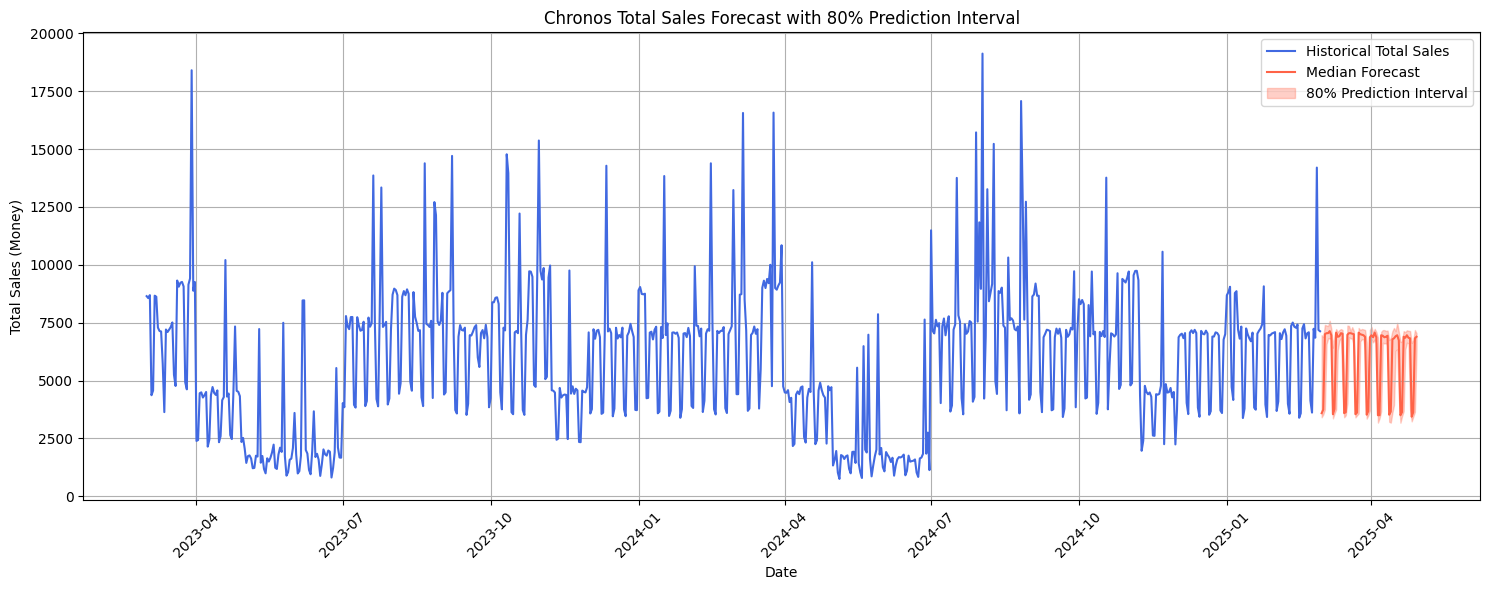

In [189]:
# Visualize the Chronos forecast with prediction interval
plt.figure(figsize=(15, 6))

# Plot historical data (daily_total_sales before split_date)
plt.plot(historical_sales_before_split['date'], historical_sales_before_split['total_sales'], color="royalblue", label="Historical Total Sales")

# Create dates for the forecast period
# The forecast starts immediately after the last date in the historical_sales_before_split
last_date_historical = historical_sales_before_split['date'].iloc[-1]
forecast_dates = pd.date_range(start=last_date_historical + pd.Timedelta(days=1), periods=prediction_length, freq='D')

# Calculate quantiles for the prediction interval
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

# Plot the median forecast
plt.plot(forecast_dates, median, color="tomato", label="Median Forecast")

# Plot the 80% prediction interval
plt.fill_between(forecast_dates, low, high, color="tomato", alpha=0.3, label="80% Prediction Interval")


plt.title('Chronos Total Sales Forecast with 80% Prediction Interval')
plt.xlabel('Date')
plt.ylabel('Total Sales (Money)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [190]:
forecast[0][:][0]

tensor([3722.3364, 3810.9634, 7001.5371, 7311.7324, 7001.5371, 7311.7324,
        7223.1055, 3234.8877, 3855.2769, 6912.9102, 7001.5371, 7045.8506,
        7045.8506, 7178.7920, 3412.1416, 3722.3364, 7311.7324, 6912.9102,
        7134.4785, 7045.8506, 7134.4785, 3545.0825, 3589.3960, 6824.2832,
        7178.7920, 6868.5967, 7090.1641, 6868.5967, 3367.8281, 3678.0229,
        6691.3428, 6912.9102, 6824.2832, 6779.9697, 6957.2236, 3545.0825,
        3412.1416, 7001.5371, 6912.9102, 6868.5967, 6824.2832, 6912.9102,
        3456.4551, 3412.1416, 6957.2236, 6824.2832, 6824.2832, 6912.9102,
        6647.0293, 3412.1416, 3456.4551, 6912.9102, 6868.5967, 6691.3428,
        6824.2832, 6735.6562, 3367.8281, 3589.3960, 6912.9102, 6868.5967])

In [191]:
median_forecast = np.median(forecast[0], axis=0)

print("ค่ามัธยฐานของผลการพยากรณ์ 12 เดือนข้างหน้า")
print(median_forecast)

ค่ามัธยฐานของผลการพยากรณ์ 12 เดือนข้างหน้า
[3589.396  3744.4932 7001.537  7045.8506 7045.8506 7134.4785 6957.2236
 3545.0825 3766.65   7068.0073 6890.7534 6912.91   7045.8506 7023.694
 3589.396  3633.7095 6979.3804 7045.8506 7045.8506 7023.694  7001.537
 3545.0825 3611.5527 7068.0073 7001.537  6979.3804 6957.2236 6890.7534
 3522.9255 3678.023  6868.5967 6957.2236 6868.5967 7068.0073 6868.5967
 3500.7686 3500.7686 6957.2236 6935.067  6868.5967 6890.7534 6935.067
 3522.9255 3655.8662 6779.9697 6824.283  6912.91   6957.2236 6735.6562
 3500.7686 3633.7095 6890.7534 6846.44   6957.2236 6846.44   6824.283
 3434.2983 3633.7095 6824.283  6890.7534]




##Predic จำนวนแก้วที่ขายได้ในแต่ละวันโดยแยกเป็นแต่ละเมนู เป็นเวลา 2 เดือน


Saving cafethai_prices.csv to cafethai_prices.csv
Americano: ค่าเฉลี่ยต่อวัน = 13.70 แก้ว, คาดว่า 60 วัน ≈ 822 แก้ว


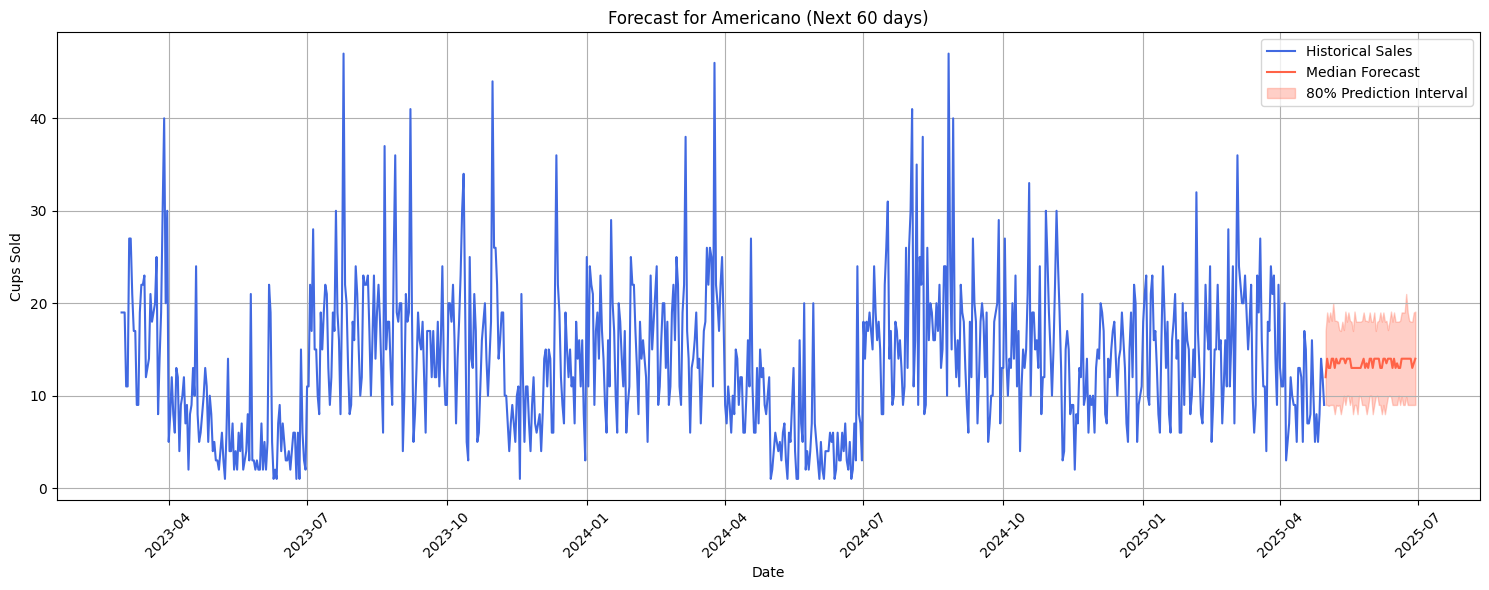

Americano with Milk: ค่าเฉลี่ยต่อวัน = 19.16 แก้ว, คาดว่า 60 วัน ≈ 1149 แก้ว


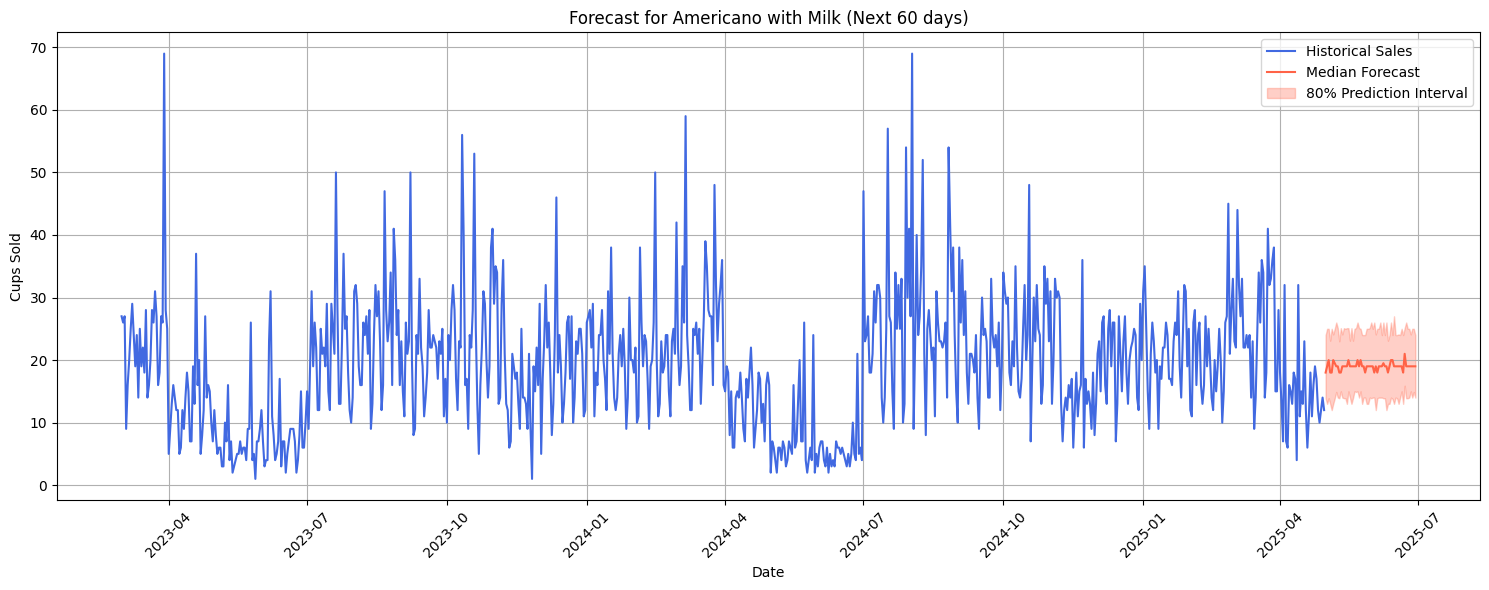

Cappuccino: ค่าเฉลี่ยต่อวัน = 12.38 แก้ว, คาดว่า 60 วัน ≈ 743 แก้ว


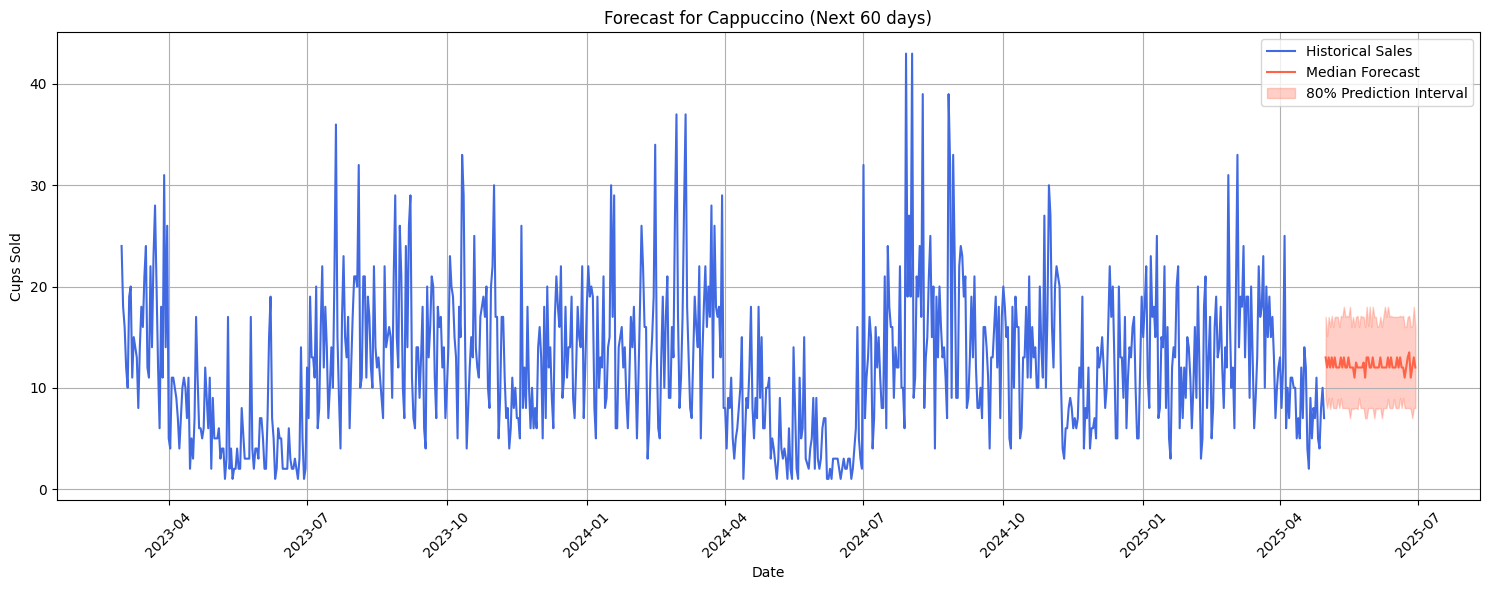

Cocoa: ค่าเฉลี่ยต่อวัน = 5.85 แก้ว, คาดว่า 60 วัน ≈ 351 แก้ว


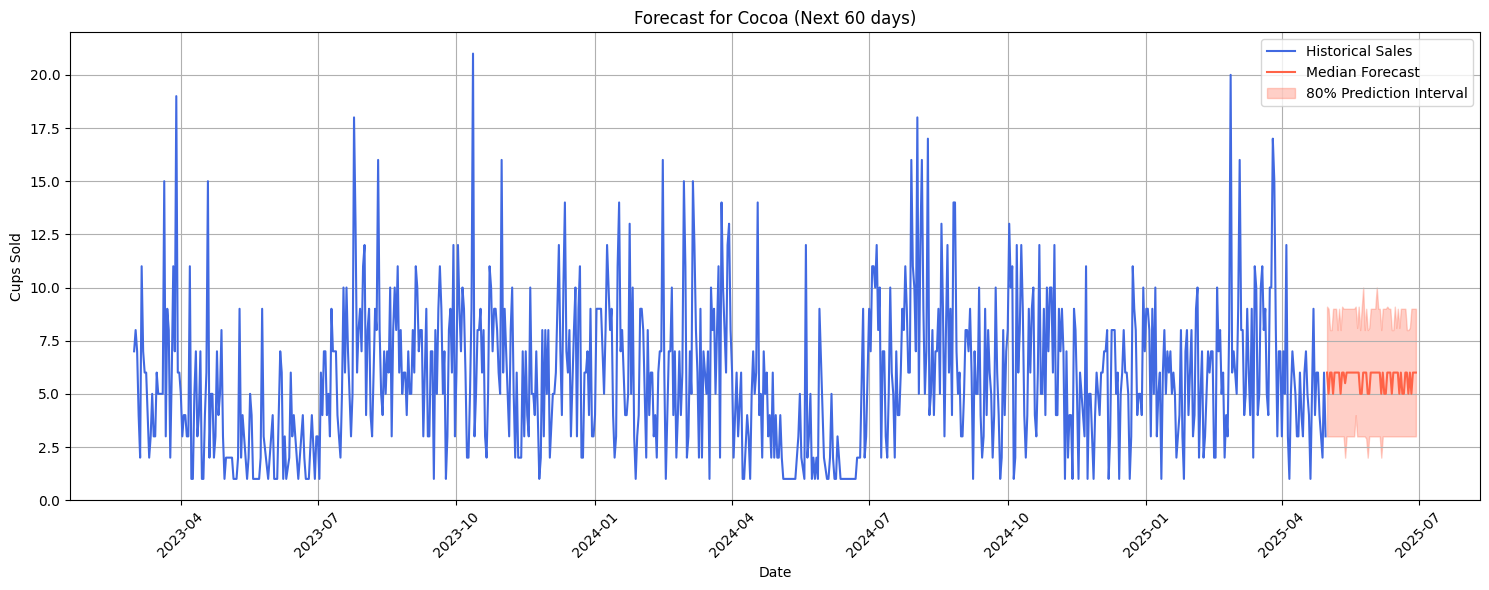

Cortado: ค่าเฉลี่ยต่อวัน = 7.02 แก้ว, คาดว่า 60 วัน ≈ 421 แก้ว


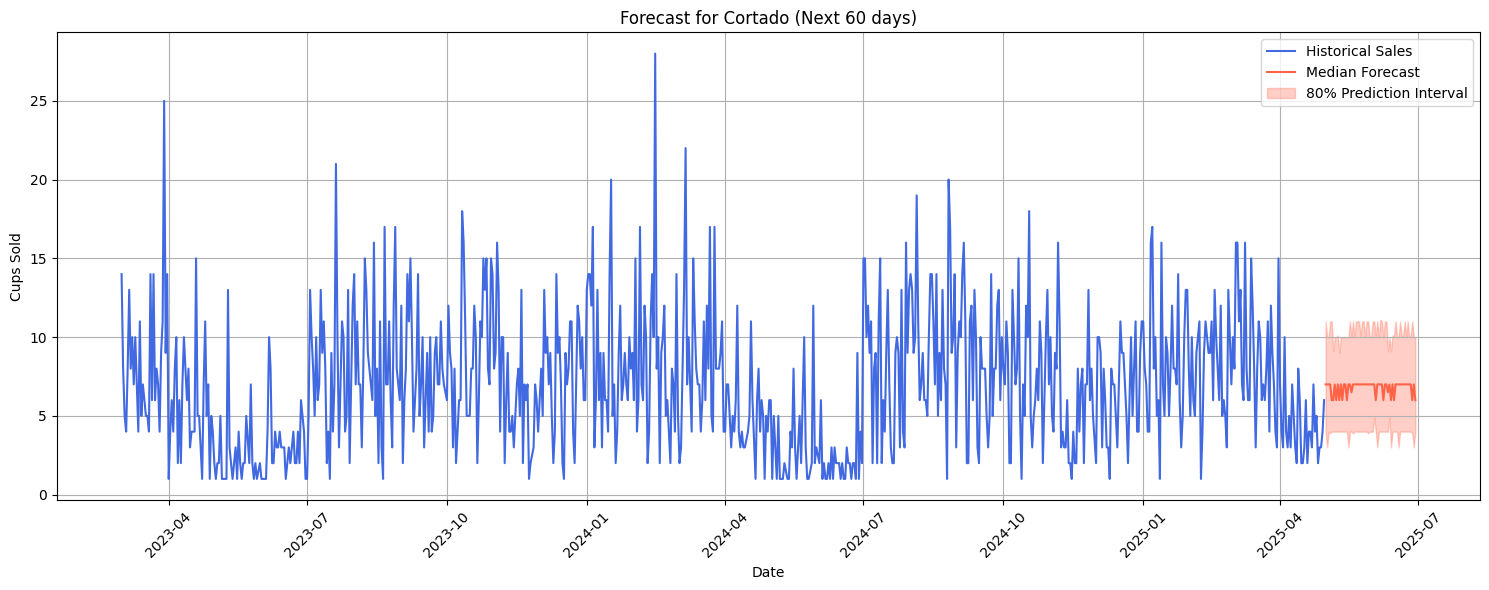

Espresso: ค่าเฉลี่ยต่อวัน = 3.70 แก้ว, คาดว่า 60 วัน ≈ 222 แก้ว


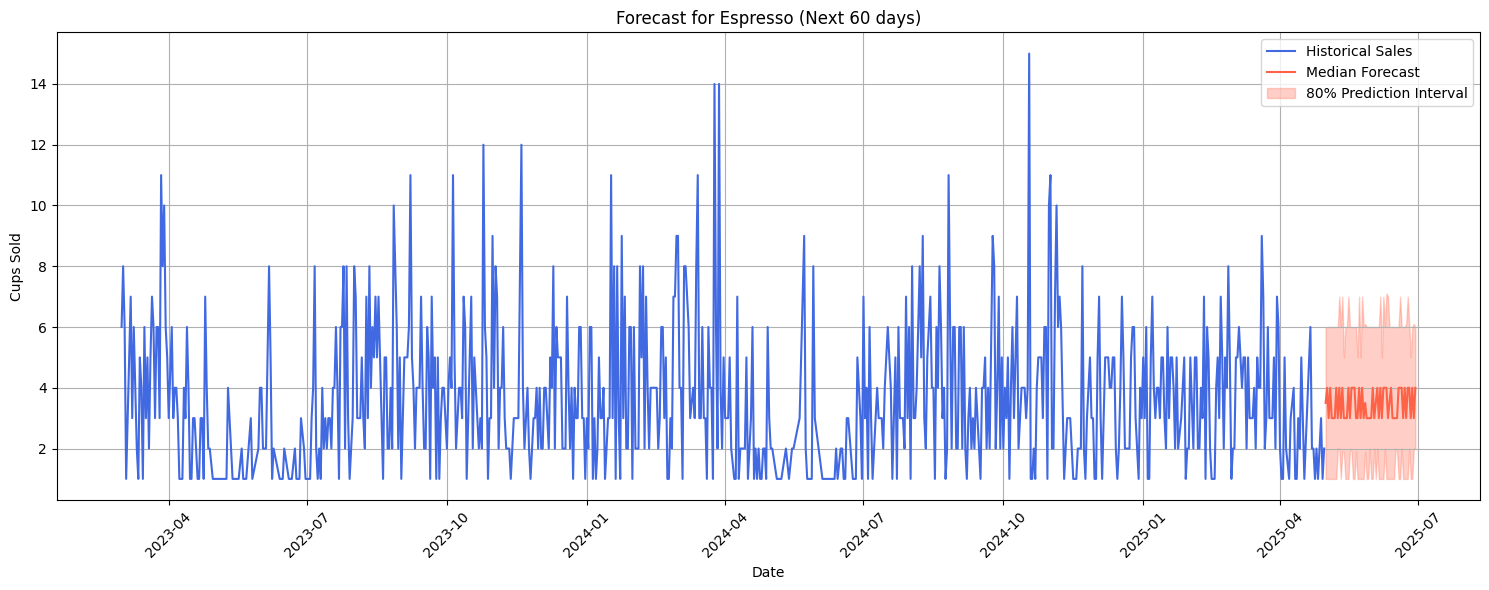

Hot Chocolate: ค่าเฉลี่ยต่อวัน = 6.98 แก้ว, คาดว่า 60 วัน ≈ 419 แก้ว


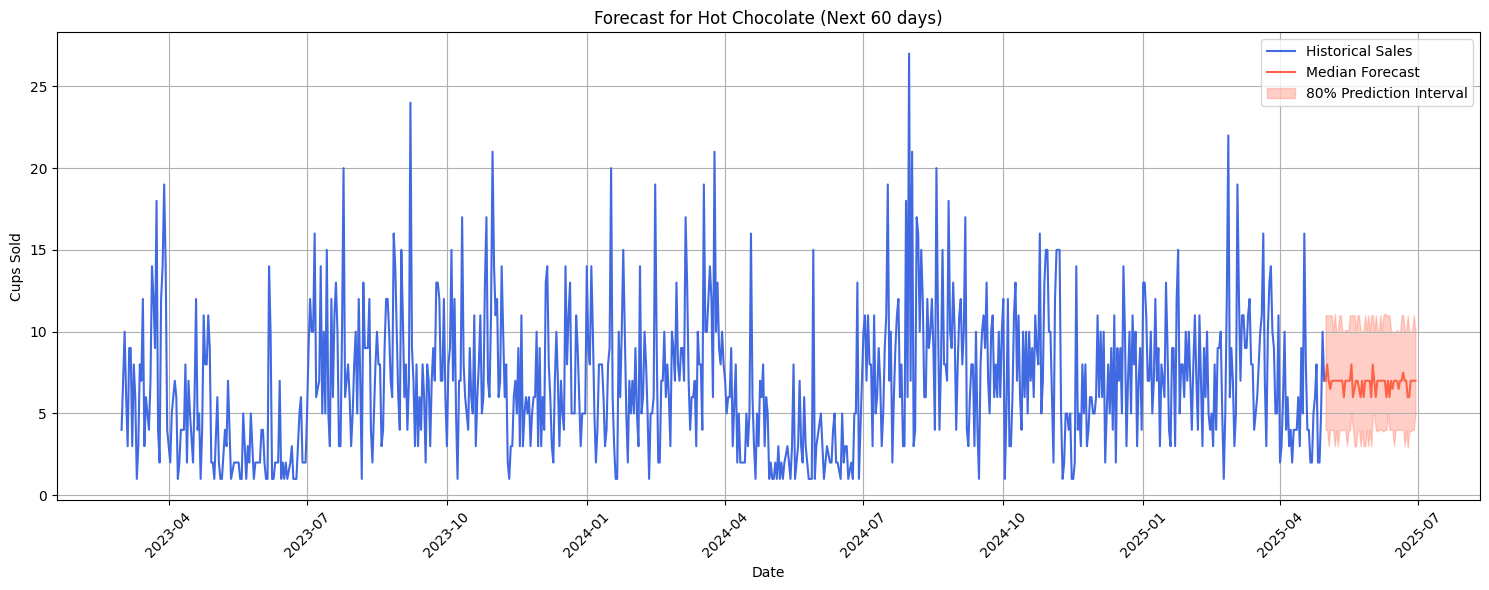

Latte: ค่าเฉลี่ยต่อวัน = 18.70 แก้ว, คาดว่า 60 วัน ≈ 1122 แก้ว


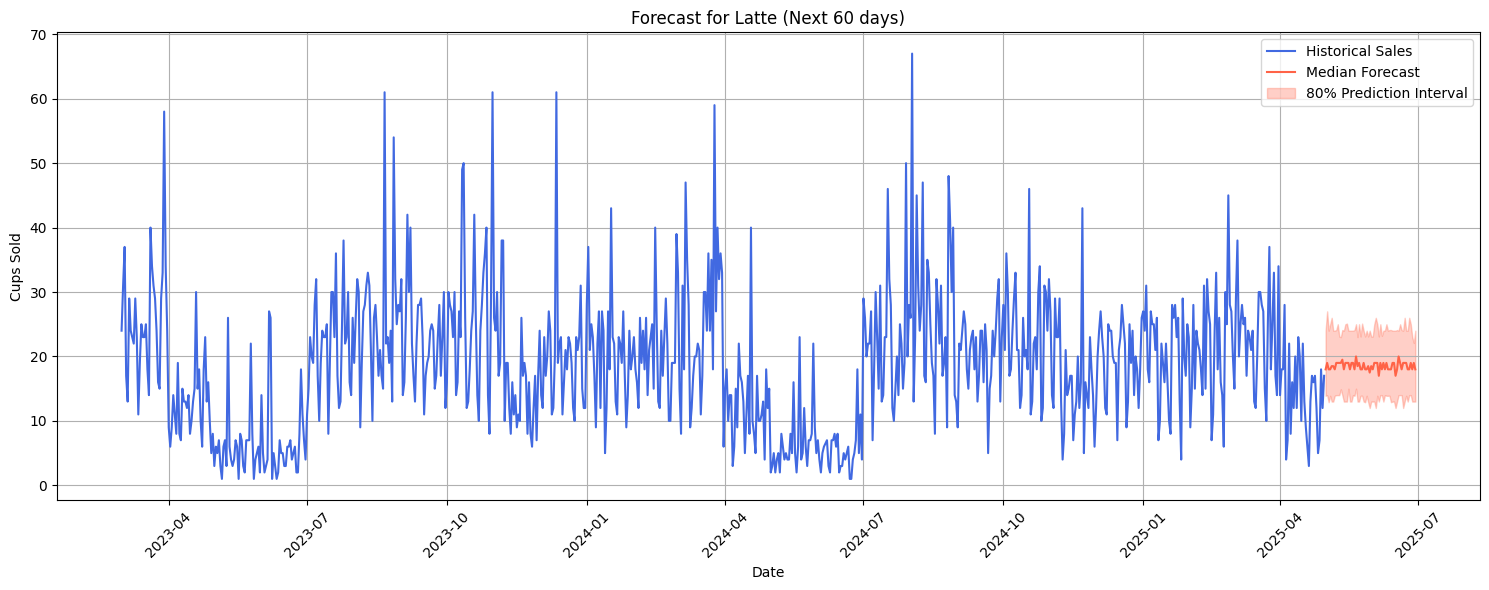


✅ จำนวนแก้วที่ขายได้ในแต่ละวันโดยแยกเป็นแต่ละเมนู เป็นเวลา 2 เดือน  5249 แก้ว


In [202]:
# ============================
# Forecast Coffee Sales in 60 Days
# ============================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# --- อัปโหลดไฟล์ CSV ---
uploaded = files.upload()

#ไฟล์ชื่อ "cafethai_prices.csv"
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename)
df["date"] = pd.to_datetime(df["date"], dayfirst=True)

# สรุปยอดขายต่อวันต่อเมนู
sales_by_product = df.groupby(["date", "coffee_name"]).size().reset_index(name="cups")

# ตั้งค่าระยะเวลาพยากรณ์ (60 วัน = ~2 เดือน)
prediction_length = 60

forecasts = {}
total_expected_sales = 0  # เก็บยอดรวมทุกรายการ

for product in sales_by_product["coffee_name"].unique():
    product_data = sales_by_product[sales_by_product["coffee_name"] == product].copy()
    product_data = product_data.sort_values("date")

    # ค่าเฉลี่ยต่อวัน
    avg_daily_sales = product_data["cups"].mean()

    # คาดการณ์ยอดขายรวม 60 วัน
    expected_2months_sales = avg_daily_sales * prediction_length
    total_expected_sales += expected_2months_sales

    print(f"{product}: ค่าเฉลี่ยต่อวัน = {avg_daily_sales:.2f} แก้ว,"
          f" คาดว่า 60 วัน ≈ {expected_2months_sales:.0f} แก้ว")

    # สร้างช่วงวันที่อนาคต
    last_date_historical = product_data["date"].iloc[-1]
    forecast_dates = pd.date_range(start=last_date_historical + pd.Timedelta(days=1),
                                   periods=prediction_length, freq="D")

    # สุ่มการขายด้วย Poisson distribution
    forecast = np.random.poisson(lam=avg_daily_sales, size=(100, prediction_length))

    low, median, high = np.quantile(forecast, [0.1, 0.5, 0.9], axis=0)

    forecasts[product] = {
        "dates": forecast_dates,
        "median": median,
        "low": low,
        "high": high
    }

    # วาดกราฟ
    plt.figure(figsize=(15, 6))
    plt.plot(product_data["date"], product_data["cups"], color="royalblue", label="Historical Sales")
    plt.plot(forecast_dates, median, color="tomato", label="Median Forecast")
    plt.fill_between(forecast_dates, low, high, color="tomato", alpha=0.3, label="80% Prediction Interval")

    plt.title(f"Forecast for {product} (Next {prediction_length} days)")
    plt.xlabel("Date")
    plt.ylabel("Cups Sold")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

print(f"\n✅ จำนวนแก้วที่ขายได้ในแต่ละวันโดยแยกเป็นแต่ละเมนู เป็นเวลา 2 เดือน  {total_expected_sales:.0f} แก้ว")


##ค่ามัธยฐานของจำนวนแก้วในอีก 2 เดือน


In [197]:
# ดูเมนูทั้งหมดที่มีในข้อมูล
menu_list = df["coffee_name"].unique()
print("📌 เมนูทั้งหมดในไฟล์:")
for m in menu_list:
    print("-", m)


📌 เมนูทั้งหมดในไฟล์:
- Latte
- Americano with Milk
- Cappuccino
- Cortado
- Americano
- Hot Chocolate
- Cocoa
- Espresso


2025-01-01: มัธยฐาน ≈ 7018 แก้ว
2025-01-02: มัธยฐาน ≈ 7002 แก้ว
2025-01-03: มัธยฐาน ≈ 6994 แก้ว
2025-01-04: มัธยฐาน ≈ 7011 แก้ว
2025-01-05: มัธยฐาน ≈ 6982 แก้ว
2025-01-06: มัธยฐาน ≈ 7006 แก้ว
2025-01-07: มัธยฐาน ≈ 6998 แก้ว
2025-01-08: มัธยฐาน ≈ 7020 แก้ว
2025-01-09: มัธยฐาน ≈ 6976 แก้ว
2025-01-10: มัธยฐาน ≈ 7003 แก้ว
2025-01-11: มัธยฐาน ≈ 6986 แก้ว
2025-01-12: มัธยฐาน ≈ 6992 แก้ว
2025-01-13: มัธยฐาน ≈ 7006 แก้ว
2025-01-14: มัธยฐาน ≈ 6992 แก้ว
2025-01-15: มัธยฐาน ≈ 7001 แก้ว
2025-01-16: มัธยฐาน ≈ 6988 แก้ว
2025-01-17: มัธยฐาน ≈ 7009 แก้ว
2025-01-18: มัธยฐาน ≈ 6998 แก้ว
2025-01-19: มัธยฐาน ≈ 6984 แก้ว
2025-01-20: มัธยฐาน ≈ 7003 แก้ว
2025-01-21: มัธยฐาน ≈ 7002 แก้ว
2025-01-22: มัธยฐาน ≈ 7012 แก้ว
2025-01-23: มัธยฐาน ≈ 7000 แก้ว
2025-01-24: มัธยฐาน ≈ 6999 แก้ว
2025-01-25: มัธยฐาน ≈ 6984 แก้ว
2025-01-26: มัธยฐาน ≈ 6995 แก้ว
2025-01-27: มัธยฐาน ≈ 6996 แก้ว
2025-01-28: มัธยฐาน ≈ 7016 แก้ว
2025-01-29: มัธยฐาน ≈ 6996 แก้ว
2025-01-30: มัธยฐาน ≈ 6990 แก้ว
2025-01-31: มัธยฐาน ≈ 7007 แก้ว
2025-02-

/tmp/ipython-input-2766607486.py:34: UserWarning: Glyph 3588 (\N{THAI CHARACTER KHO KHWAI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2766607486.py:34: UserWarning: Glyph 3656 (\N{THAI CHARACTER MAI EK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2766607486.py:34: UserWarning: Glyph 3634 (\N{THAI CHARACTER SARA AA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2766607486.py:34: UserWarning: Glyph 3617 (\N{THAI CHARACTER MO MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2766607486.py:34: UserWarning: Glyph 3633 (\N{THAI CHARACTER MAI HAN-AKAT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2766607486.py:34: UserWarning: Glyph 3608 (\N{THAI CHARACTER THO THONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-2766607486.py:34: UserWarning: Glyph 3618 (\N{THAI CHARACTER YO YAK}) missing from font(s) DejaVu Sans.
 

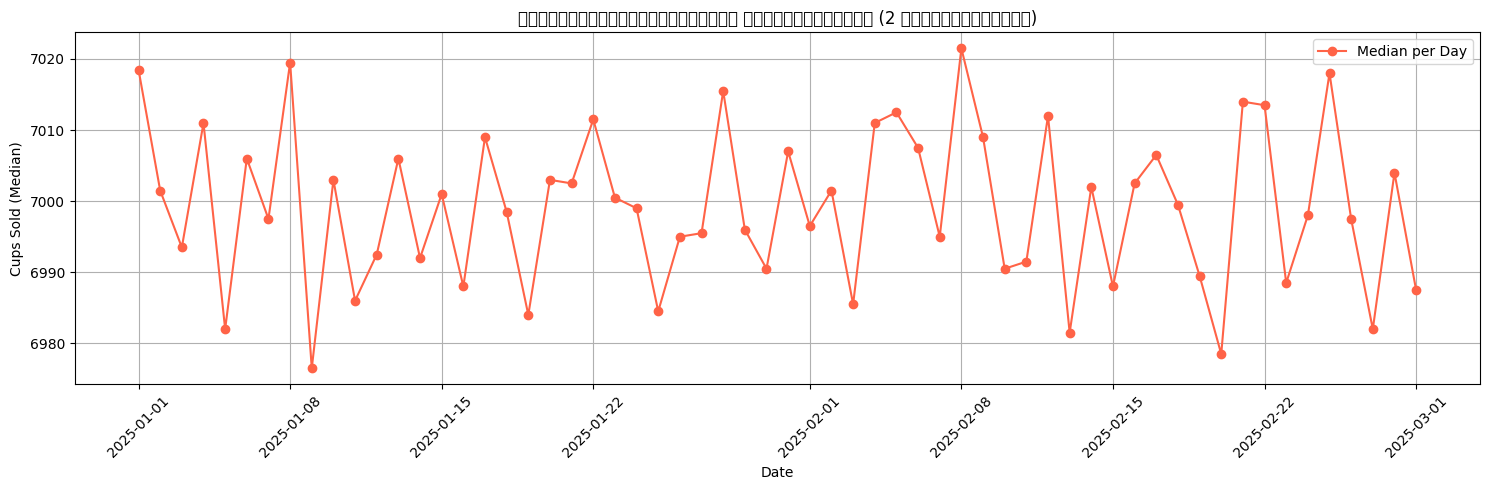

In [210]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

prediction_length = 60  # 2 เดือน
np.random.seed(42)

avg_sales = 7000  # ค่าเฉลี่ยต่อวัน

# กำหนดวันที่เริ่มจากปีล่าสุด
today = pd.Timestamp.today()
start_date = pd.Timestamp(year=today.year, month=1, day=1)
forecast_dates = pd.date_range(start=start_date, periods=prediction_length, freq="D")

# จำลองยอดขายต่อวัน (100 รอบ x 60 วัน)
forecast = np.random.poisson(lam=avg_sales, size=(100, prediction_length))

# หาค่ามัธยฐานต่อวัน
median_per_day = np.median(forecast, axis=0)

# แสดงผล
for date, median_val in zip(forecast_dates, median_per_day):
    print(f"{date.date()}: มัธยฐาน ≈ {median_val:.0f} แก้ว")

# --- วาดกราฟมัธยฐานต่อวัน ---
plt.figure(figsize=(15,5))
plt.plot(forecast_dates, median_per_day, color="tomato", marker="o", label="Median per Day")
plt.title("ค่ามัธยฐานยอดขายต่อวัน แสดงจำนวนแก้ว (2 เดือนข้างหน้า)")
plt.xlabel("Date")
plt.ylabel("Cups Sold (Median)")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
